# DIGI405-20S1 - Topic Modeling TED.com transcripts

This notebook introduces Gensim for topic modeling of  The TED.com corpus.

Since we need to evaluate topic models against a use case - think about the idea of a recommendation engine: what model performs best for finding similiar TED talks?

In [1]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models.wrappers import LdaMallet
from gensim.models.coherencemodel import CoherenceModel
from gensim import similarities

import os.path
import re
import glob

import pandas as pd
import matplotlib as plt

mallet_path = '/opt/mallet-2.0.8/bin/mallet' # this should be the correct path for the DIGI405 lab workrooms

In [2]:
# to install nltk run this in Anaconda prompt: pip install nltk 
# note if you get an error with stopwords below then uncomment the following lines and rerun this cell 
# import nltk
# nltk.download('stopwords')

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

The following cells contain functions to load a corpus from a directory of text files, preprocess the corpus and create the bag of words document-term matrix. 

In [3]:
def load_data_from_dir(path):
    file_list = glob.glob(path + '/*.txt')

    # create document list:
    documents_list = []
    for filename in file_list:
        with open(filename, 'r', encoding='utf8') as f:
            text = f.read()
            f.close()
            documents_list.append(text)
    print("Total Number of Documents:",len(documents_list))
    return documents_list

In [4]:
def preprocess_data(doc_set,extra_stopwords = {}):
    # adapted from https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python
    # replace all newlines or multiple sequences of spaces with a standard space
    doc_set = [re.sub('\s+', ' ', doc) for doc in doc_set]
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # add any extra stopwords
    if (len(extra_stopwords) > 0):
        en_stop = en_stop.union(extra_stopwords)
    
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # add tokens to list
        texts.append(stopped_tokens)
    return texts

In [5]:
def prepare_corpus(doc_clean):
    # adapted from https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    
    dictionary.filter_extremes(no_below=5, no_above=0.5)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

    return dictionary,doc_term_matrix

## Load and pre-process the corpus
Load the corpus, preprocess with additional stop words and output dictionary and document-term matrix.

In [6]:
# Getting the TED Corpus
document_list = load_data_from_dir("transcripts")

# Adding NLTK's stopword list
doc_clean = preprocess_data(document_list,{'laughter','applause'})

dictionary, doc_term_matrix = prepare_corpus(doc_clean)

Total Number of Documents: 3603


## LDA model with 20 topics
The following cell sets the number of topics we are training the model for. The one after trains the model and outputs the topics. Note: this can take a while!

In [7]:
number_of_topics= 45 # adjust this to alter the number of topics
words=20 #adjust this to alter the number of words output for the topic below

In [8]:
# runs LDA using Mallet from gensim using the number_of_topics specified above - this might take a couple of minutes
# create additional variables eg ldamallet20 to store models with different numbers of topics
ldamallet45 = LdaMallet(mallet_path, corpus=doc_term_matrix, num_topics=number_of_topics, id2word=dictionary)

In [9]:
# output of the 45 topics with 20 words in each topic
ldamallet45.show_topics(num_topics=number_of_topics,num_words=words)

[(0,
  '0.019*"body" + 0.018*"robot" + 0.012*"robots" + 0.011*"fly" + 0.011*"move" + 0.009*"feet" + 0.009*"legs" + 0.007*"foot" + 0.007*"air" + 0.007*"flying" + 0.007*"moving" + 0.006*"control" + 0.006*"speed" + 0.006*"arm" + 0.006*"flight" + 0.005*"video" + 0.005*"leg" + 0.005*"side" + 0.005*"ground" + 0.004*"small"'),
 (1,
  '0.055*"earth" + 0.029*"planet" + 0.028*"space" + 0.014*"mars" + 0.014*"moon" + 0.013*"system" + 0.011*"planets" + 0.010*"surface" + 0.009*"sun" + 0.009*"solar" + 0.009*"science" + 0.007*"atmosphere" + 0.007*"star" + 0.006*"nasa" + 0.006*"clouds" + 0.006*"ice" + 0.005*"satellite" + 0.005*"picture" + 0.005*"place" + 0.005*"stars"'),
 (2,
  '0.019*"sleep" + 0.015*"feel" + 0.013*"pain" + 0.012*"happiness" + 0.011*"mind" + 0.011*"stress" + 0.011*"experience" + 0.011*"mental" + 0.010*"attention" + 0.010*"emotions" + 0.010*"depression" + 0.009*"happy" + 0.009*"feeling" + 0.007*"emotional" + 0.007*"physical" + 0.006*"emotion" + 0.006*"response" + 0.006*"anxiety" + 0.005

## Convert to Gensim model format
Convert the Mallet model to gensim format.

In [10]:
gensimmodel45 = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet45)

## Get a coherence score

In [11]:
coherencemodel = CoherenceModel(model=gensimmodel45, texts=doc_clean, dictionary=dictionary, coherence='c_v')
print (coherencemodel.get_coherence())

0.548369313740069


## Calculate coherence scores for models with different numbers of topics


The code block below will train a model with 35 topics and return the coherence score. 

In [12]:
ldamallet35 = LdaMallet(mallet_path, corpus=doc_term_matrix, num_topics=35, id2word=dictionary)
gensimmodel35 = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet35)
coherencemodel = CoherenceModel(model=gensimmodel35, texts=doc_clean, dictionary=dictionary, coherence='c_v')
print (coherencemodel.get_coherence())

0.5491135315087162


## Test a range of topic sizes and plot the results

**Important**: this process will take a while to run! Make sure you have tried a number topic sizes to get a sense of what models you need to test. I suggest you test no more than 8-10 models using the code below, so as not to be waiting too long!

In [13]:
# supply values for k and the interval, eg 20, 60, 10 will train models for 20, 30, 40, 50, and 60 topics
min_k = 10
max_k = 70
intervals = 15

coherences = {}

for i in range(min_k, max_k, intervals):
    ldamalletmodel = LdaMallet(mallet_path, corpus=doc_term_matrix, num_topics=i, id2word=dictionary)
    gensimmodel = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamalletmodel)
    coherences[i] = CoherenceModel(model=gensimmodel, texts=doc_clean, dictionary=dictionary, coherence='c_v').get_coherence()

In [14]:
# convert the coherence scores to a pandas dataframe
df = pd.DataFrame.from_dict(coherences, orient='index', columns=['Coherence'])
df['Topics'] = df.index

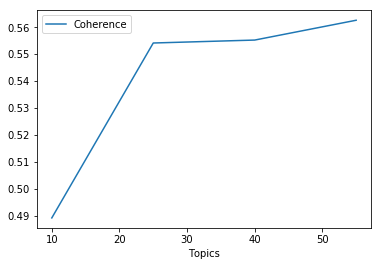

In [22]:
# plot the result
df.plot(kind='line', x='Topics', y='Coherence')

## Preview a document

Preview a document - you can change the doc_id to view another document.

In [16]:
doc_id = 1082 # index of document to explore
print(re.sub('\s+', ' ', document_list[doc_id])) 

How many decisions have been made about you today, or this week or this year, by artificial intelligence? I build AI for a living so, full disclosure, I'm kind of a nerd. And because I'm kind of a nerd, wherever some new news story comes out about artificial intelligence stealing all our jobs, or robots getting citizenship of an actual country, I'm the person my friends and followers message freaking out about the future. We see this everywhere. This media panic that our robot overlords are taking over. We could blame Hollywood for that. But in reality, that's not the problem we should be focusing on. There is a more pressing danger, a bigger risk with AI, that we need to fix first. So we are back to this question: How many decisions have been made about you today by AI? And how many of these were based on your gender, your race or your background? Algorithms are being used all the time to make decisions about who we are and what we want. Some of the women in this room will know what I

## Output the distribution of topics for the document

The next cell outputs the distribution of topics on the document specified above.

In [17]:
document_topics = gensimmodel45.get_document_topics(doc_term_matrix[doc_id]) # substitute other models here
document_topics = sorted(document_topics, key=lambda x: x[1], reverse=True) # sorts document topics

for topic, prop in document_topics:
    topic_words = [word[0] for word in gensimmodel45.show_topic(topic, 20)]
    print ("%.2f" % prop, topic, topic_words)

0.21 32 ['technology', 'computer', 'machine', 'computers', 'human', 'machines', 'digital', 'device', 'software', 'future', 'phone', 'technologies', 'build', 'real', 'devices', 'system', 'built', 'code', 'video', 'information']
0.10 23 ['women', 'men', 'woman', 'girls', 'sex', 'girl', 'gender', 'female', 'male', 'young', 'sexual', 'man', 'boys', 'body', 'mother', 'talk', 'baby', 'birth', 'marriage', 'babies']
0.08 6 ['internet', 'information', 'media', 'online', 'google', 'facebook', 'web', 'open', 'content', 'news', 'twitter', 'phone', 'public', 'website', 'email', 'social', 'share', 'free', 'page', 'government']
0.07 21 ['question', 'wrong', 'answer', 'questions', 'problem', 'bad', 'true', 'choice', 'reason', 'reality', 'moral', 'truth', 'decisions', 'hard', 'asked', 'decision', 'news', 'point', 'choices', 'case']
0.06 25 ['company', 'working', 'job', 'success', 'ideas', 'business', 'idea', 'team', 'trust', 'rules', 'organization', 'leadership', 'successful', 'start', 'failure', 'orga

## Find similar documents
This will find the 5 most similar documents to the document specified above based on their topic distribution. The MatrixSimilarity() method uses cosine similarity to measure how similar the document specified by `docid` is to all other documents for that model. There are better measures, but this one is quick and simple to implement.

In [18]:
model_doc_topics = gensimmodel45.get_document_topics(doc_term_matrix) # substitute other models here
lda_index = similarities.MatrixSimilarity(model_doc_topics.corpus)
    
# query for our doc_id from above
similarity_index = lda_index[doc_term_matrix[doc_id]]
# Sort the similarity index
similarity_index = sorted(enumerate(similarity_index), key=lambda item: -item[1])

for i in range(1,6): 
    document_id, similarity_score = similarity_index[i]
    print('Document Index: ',document_id)
    print('Similarity Score',similarity_score)
    print(re.sub('\s+', ' ', document_list[document_id][:500]), '...') # preview first 500 characters
    print()

Document Index:  838
Similarity Score 0.55921584
After 13.8 billion years of cosmic history, our universe has woken up and become aware of itself. From a small blue planet, tiny, conscious parts of our universe have begun gazing out into the cosmos with telescopes, discovering something humbling. We've discovered that our universe is vastly grander than our ancestors imagined and that life seems to be an almost imperceptibly small perturbation on an otherwise dead universe. But we've also discovered something inspiring, which is that the techn ...

Document Index:  2472
Similarity Score 0.44443643
I'm here to offer you a new way to think about my field, artificial intelligence. I think the purpose of AI is to empower humans with machine intelligence. And as machines get smarter, we get smarter. I call this "humanistic AI" — artificial intelligence designed to meet human needs by collaborating and augmenting people. Now, today I'm happy to see that the idea of an intelligent assistant i

In [19]:
doc_id = 136 # index of document to explore
print(re.sub('\s+', ' ', document_list[doc_id])) 

In this talk today, I want to present a different idea for why investing in early childhood education makes sense as a public investment. It's a different idea, because usually, when people talk about early childhood programs, they talk about all the wonderful benefits for participants in terms of former participants, in preschool, they have better K-12 test scores, better adult earnings. Now that's all very important, but what I want to talk about is what preschool does for state economies and for promoting state economic development. And that's actually crucial because if we're going to get increased investment in early childhood programs, we need to interest state governments in this. The federal government has a lot on its plate, and state governments are going to have to step up. So we have to appeal to them, the legislators in the state government, and turn to something they understand, that they have to promote the economic development of their state economy. Now, by promoting e

In [20]:
document_topics = gensimmodel45.get_document_topics(doc_term_matrix[doc_id]) # substitute other models here
document_topics = sorted(document_topics, key=lambda x: x[1], reverse=True) # sorts document topics

for topic, prop in document_topics:
    topic_words = [word[0] for word in gensimmodel45.show_topic(topic, 20)]
    print ("%.2f" % prop, topic, topic_words)

0.32 38 ['money', 'dollars', 'business', 'market', 'companies', 'buy', 'pay', 'company', 'economy', 'jobs', 'percent', 'industry', 'economic', 'financial', 'sell', 'price', 'cost', 'government', 'paid', 'product']
0.16 30 ['school', 'kids', 'children', 'students', 'education', 'child', 'parents', 'learning', 'high', 'learn', 'teachers', 'schools', 'teach', 'class', 'college', 'teacher', 'young', 'student', 'teaching', 'kid']
0.10 12 ['study', 'research', 'found', 'social', 'group', 'science', 'studies', 'behavior', 'age', 'experiment', 'effect', 'turns', 'scientists', 'percent', 'person', 'older', 'test', 'positive', 'results', 'asked']
0.06 11 ['city', 'cities', 'public', 'place', 'live', 'york', 'community', 'home', 'street', 'places', 'building', 'urban', 'space', 'house', 'built', 'park', 'streets', 'neighborhood', 'local', 'living']
0.05 8 ['countries', 'africa', 'china', 'country', 'india', 'global', 'growth', 'chinese', 'economic', 'states', 'united', 'african', 'europe', 'popul

In [21]:
model_doc_topics = gensimmodel45.get_document_topics(doc_term_matrix) # substitute other models here
lda_index = similarities.MatrixSimilarity(model_doc_topics.corpus)
    
# query for our doc_id from above
similarity_index = lda_index[doc_term_matrix[doc_id]]
# Sort the similarity index
similarity_index = sorted(enumerate(similarity_index), key=lambda item: -item[1])

for i in range(1,6): 
    document_id, similarity_score = similarity_index[i]
    print('Document Index: ',document_id)
    print('Similarity Score',similarity_score)
    print(re.sub('\s+', ' ', document_list[document_id][:500]), '...') # preview first 500 characters
    print()

Document Index:  2046
Similarity Score 0.3059151
Have you ever asked yourselves why it is that companies, the really cool companies, the innovative ones, the creative, new economy-type companies — Apple, Google, Facebook — are coming out of one particular country, the United States of America? Usually when I say this, someone says, "Spotify! That's Europe." But, yeah. It has not had the impact that these other companies have had. Now what I do is I'm an economist, and I actually study the relationship between innovation and economic growth at ...

Document Index:  2855
Similarity Score 0.29231533
I'm an historian. And what I love about being an historian is it gives you perspective. Today, I'd like to bring that perspective to education in the United States. About the only thing people can agree on is that the most strategic time for a child to start learning is early. Over 50 years ago, there was a watershed moment in early education in the US called "Head Start." Now, historians love